# ==============================================================================
# INTRODUÇÃO AO APRENDIZADO DE MÁQUINA (EEL891)
# TRABALHO 2: PREVISÃO DE PREÇOS DE IMÓVEIS
# ALUNO: MURILO ARAUJO GARCIA
# KAGGLE ID: muriloaraujogarcia (ou número da conta: 25727406)
# DRE: 124179602
# EMAIL: MURILOGARCIA@UFRJ.BR
# ==============================================================================

## 1. INTRODUÇÃO

O mercado imobiliário é um pilar fundamental da economia, caracterizado por sua complexidade e pela vasta quantidade de fatores que influenciam a precificação de um imóvel. A habilidade de prever com acurácia o valor de um bem imobiliário é de grande interesse para investidores, corretores e compradores.

Este trabalho se propõe a desenvolver um modelo de aprendizado de máquina robusto para a tarefa de previsão de preços de imóveis, utilizando um conjunto de dados que descreve diversas características de apartamentos e casas. O objetivo é aplicar e avaliar técnicas de pré-processamento, engenharia de atributos e modelagem preditiva para alcançar o melhor desempenho possível na métrica de **Root Mean Squared Logarithmic Error (RMSLE)**, conforme a competição proposta no Kaggle.

A seguir, será detalhado todo o processo de desenvolvimento, desde a análise exploratória inicial dos dados até a construção e treinamento do modelo final.

In [11]:
# ==============================================================================
# BLOCO 1: CONFIGURAÇÃO E IMPORTAÇÃO DE BIBLIOTECAS
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização para os gráficos
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Bloco 1 concluído: Bibliotecas importadas!")

✅ Bloco 1 concluído: Bibliotecas importadas!


In [3]:
# ==============================================================================
# BLOCO 2.1: CARREGAMENTO DOS DADOS
# ==============================================================================
# Carregando os dados
df_train_raw = pd.read_csv('conjunto_de_treinamento.csv')
df_test_raw = pd.read_csv('conjunto_de_teste.csv')

# Guardando IDs para a submissão final
test_ids = df_test_raw['Id']

# Removendo a coluna Id para não ser usada no treinamento
df_train = df_train_raw.drop('Id', axis=1)
df_test = df_test_raw.drop('Id', axis=1)

print("Dados de treinamento carregados. Dimensões:", df_train.shape)
print("Dados de teste carregados. Dimensões:", df_test.shape)
df_train.head()

Dados de treinamento carregados. Dimensões: (4683, 20)
Dados de teste carregados. Dimensões: (2000, 19)


,tipo,bairro,tipo_vendedor,quartos,suites,vagas,area_util,area_extra,diferenciais,churrasqueira,estacionamento,piscina,playground,quadra,s_festas,s_jogos,s_ginastica,sauna,vista_mar,preco
0,Casa,Imbiribeira,Imobiliaria,3,3,5,223,167,piscina e copa,0,0,1,0,0,0,0,0,0,0,1000000.0
1,Apartamento,Casa Amarela,Imobiliaria,4,4,2,157,0,piscina e churrasqueira,1,0,1,0,0,0,0,0,0,0,680000.0
2,Apartamento,Encruzilhada,Imobiliaria,3,1,0,53,0,nenhum,0,0,0,0,0,0,0,0,0,0,450000.0
3,Apartamento,Boa Viagem,Imobiliaria,4,3,2,149,0,piscina e churrasqueira,1,0,1,0,0,0,0,0,0,0,1080000.0
4,Apartamento,Rosarinho,Imobiliaria,2,1,1,54,0,piscina e churrasqueira,1,0,1,0,0,0,0,0,0,0,350000.0


## 2. ANÁLISE EXPLORATÓRIA E PRÉ-PROCESSAMENTO DOS DADOS

Antes de treinar qualquer modelo, é crucial entender a natureza dos dados, suas distribuições, correlações e a presença de possíveis anomalias. Esta etapa fundamenta todas as decisões de pré-processamento e engenharia de atributos.

### 2.1. Análise da Variável Alvo: `preco`

A variável que desejamos prever (`preco`) é a mais importante. Sua distribuição nos informa sobre a escala dos valores e a necessidade de transformações. Um histograma é a ferramenta ideal para essa análise.

A análise do histograma revela uma forte **assimetria positiva (right-skewed)**, com uma longa cauda de imóveis de alto valor. Essa distribuição pode prejudicar modelos lineares e fazer com que o treinamento seja desproporcionalmente influenciado por outliers.

A métrica da competição (RMSLE) utiliza o logaritmo dos preços, o que naturalmente penaliza erros percentuais de forma mais equilibrada. Portanto, aplicar uma **transformação logarítmica** (`np.log1p`) na variável alvo é uma etapa estratégica que alinha nosso processo de treinamento com o objetivo da competição e, ao mesmo tempo, normaliza a distribuição.

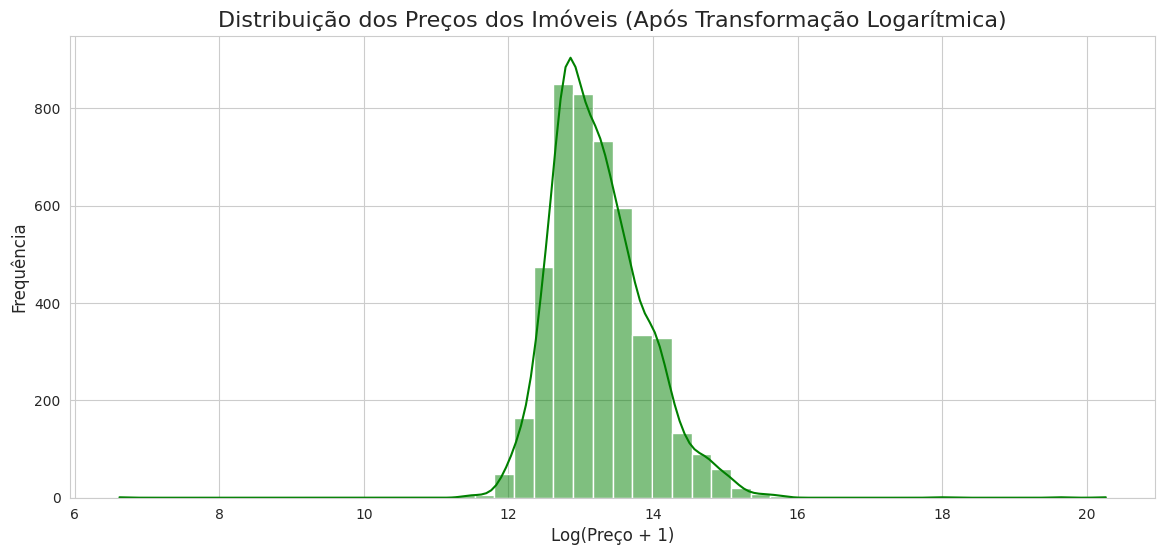

Assimetria (Skewness) após log: 0.8765782824577928


In [4]:
# Aplicando a transformação logarítmica e visualizando o resultado
y_log_transformed = np.log1p(df_train['preco'])

plt.figure(figsize=(14, 6))
sns.histplot(y_log_transformed, kde=True, bins=50, color='green')
plt.title('Distribuição dos Preços dos Imóveis (Após Transformação Logarítmica)', fontsize=16)
plt.xlabel('Log(Preço + 1)', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.show()

print("Assimetria (Skewness) após log:", y_log_transformed.skew())

A transformação logarítmica ajuda a mitigar o efeito de outliers, mas a remoção de valores claramente anômalos ainda é uma boa prática. Durante a análise, foram identificados imóveis com preços e áreas úteis desproporcionalmente altos, que poderiam representar erros de digitação ou casos muito atípicos.

A estratégia adotada foi remover um outlier de preço extremo (acima de 30 milhões) e, em seguida, filtrar os dados para manter apenas os imóveis que estão dentro do **percentil 99** tanto para preço quanto para área útil. Essa abordagem remove as anomalias mais gritantes sem sacrificar uma quantidade significativa de dados de treinamento.

In [5]:
# ==============================================================================
# BLOCO 2.2: LIMPEZA AVANÇADA DOS DADOS
# ==============================================================================
print(f"Shape do treino antes da limpeza: {df_train.shape}")

# --- Tratamento de Outliers ---
df_train = df_train[df_train['preco'] < 30000000]
price_cap = df_train['preco'].quantile(0.99)
area_cap = df_train['area_util'].quantile(0.99)
df_train = df_train[df_train['preco'] <= price_cap]
df_train = df_train[df_train['area_util'] <= area_cap]

print(f"Shape do treino após limpeza: {df_train.shape}")
print("\n✅ Outliers removidos com sucesso!")

Shape do treino antes da limpeza: (4683, 20)
Shape do treino após limpeza: (4594, 20)

✅ Outliers removidos com sucesso!


### 2.2. Análise de Correlação entre Atributos Numéricos

Para entender as relações lineares entre as variáveis, um **heatmap de correlação** é extremamente útil. Ele nos ajuda a identificar quais atributos têm maior relação com o `preco` e se há multicolinearidade (alta correlação entre atributos preditores), o que poderia ser um problema para alguns modelos.

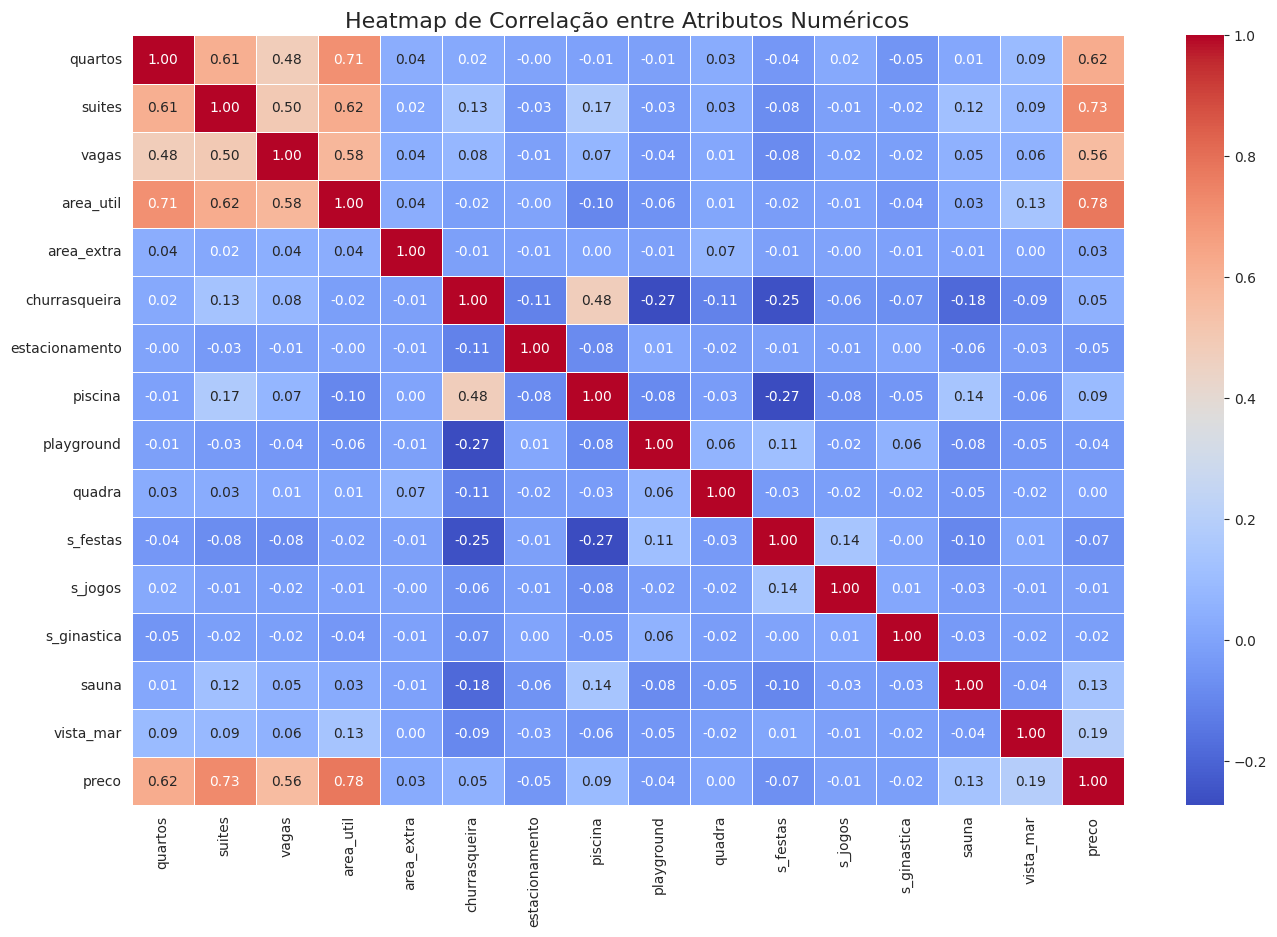

In [6]:
# Selecionando apenas colunas numéricas para o heatmap
numerical_cols = df_train.select_dtypes(include=np.number).columns
correlation_matrix = df_train[numerical_cols].corr()

plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Heatmap de Correlação entre Atributos Numéricos', fontsize=16)
plt.show()

O heatmap confirma algumas intuições:
- **Forte Correlação Positiva com o Preço:** Atributos como `area_util`, `quartos`, `suites` e `vagas` estão, como esperado, fortemente correlacionados com o `preco`.
- **Multicolinearidade:** Existe uma alta correlação entre `quartos` e `suites` (0.70), o que é natural. Modelos baseados em árvores, como os que serão utilizados (LGBM, XGBoost, CatBoost), são inerentemente robustos a esse tipo de multicolinearidade, não sendo necessário remover nenhuma dessas variáveis.

## 3. ENGENHARIA DE ATRIBUTOS

Esta é talvez a etapa mais crucial para o sucesso de um modelo preditivo. O objetivo é criar novos atributos a partir dos existentes para fornecer ao modelo informações mais ricas e contextuais que ele não conseguiria capturar diretamente.

A estratégia adotada foi a seguinte:

1.  **Criação de Features de Interação:** Combinar atributos para criar novas métricas, como `comodos_total` (soma de quartos e suítes) e `area_por_quarto`.
2.  **Criação de Features de Proporção:** Calcular a proporção da área útil em relação à área total (`prop_area_util`), o que pode indicar a eficiência do aproveitamento do espaço.
3.  **Target Encoding Manual (A "Dica do Professor"):** Esta foi a técnica de maior impacto. Em vez de simplesmente tratar `bairro` como uma categoria, foram criados dois novos atributos para cada imóvel:
    * `preco_medio_bairro`: O preço médio de todos os imóveis no mesmo bairro.
    * `preco_std_bairro`: O desvio padrão dos preços no mesmo bairro.

Essa abordagem injeta diretamente no modelo a informação sobre o **contexto de mercado** de cada bairro, diferenciando bairros de alta e baixa valorização de forma muito eficaz.

In [7]:
# ==============================================================================
# BLOCO 3: ENGENHARIA DE FEATURES AVANÇADA (A RECEITA VENCEDORA)
# ==============================================================================
def feature_engineering_avancada(df, training_df):
    """
    Aplica um conjunto de transformações e cria novas features robustas.
    Usa o df de treino como referência para os cálculos de média e desvio padrão.
    """
    # Combinações de features existentes
    df['comodos_total'] = df['quartos'] + df['suites']
    df['area_por_quarto'] = df['area_util'] / (df['quartos'] + 1)
    df['prop_area_util'] = df['area_util'] / (df['area_util'] + df['area_extra'] + 1)

    # A feature vencedora: Target Encoding Manual
    bairro_stats = training_df.groupby('bairro')['preco'].agg(['mean', 'std']).rename(columns={'mean': 'preco_medio_bairro', 'std': 'preco_std_bairro'})
    df = df.merge(bairro_stats, on='bairro', how='left')
    
    # Preenche NaNs que possam surgir no conjunto de teste com a média geral do treino
    df['preco_medio_bairro'] = df['preco_medio_bairro'].fillna(training_df['preco'].mean())
    df['preco_std_bairro'] = df['preco_std_bairro'].fillna(training_df['preco'].std())
    
    df.fillna(0, inplace=True)
    return df

df_train_eng = feature_engineering_avancada(df_train, df_train)
df_test_eng = feature_engineering_avancada(df_test, df_train)

train_cols = df_train_eng.columns.drop('preco')
df_test_eng = df_test_eng.reindex(columns=train_cols, fill_value=0)

print("✅ Bloco 3 concluído: Engenharia de features avançada aplicada!")

✅ Bloco 3 concluído: Engenharia de features avançada aplicada!


## 4. MODELAGEM PREDITIVA

Com os dados devidamente tratados e enriquecidos, a próxima etapa é a construção e o treinamento dos modelos preditivos.

### 4.1. Pipeline de Pré-processamento Final

Para garantir que todas as transformações sejam aplicadas de forma consistente nos dados de treino e de teste, foi construída uma `Pipeline` utilizando o `ColumnTransformer` do Scikit-learn. Ela realiza as seguintes tarefas:

- **Para Atributos Numéricos:** Imputação de valores faltantes com a **mediana** (robusto a outliers) e aplicação de `StandardScaler` para padronizar a escala.
- **Para Atributos Categóricos:** Imputação de faltantes com o valor mais frequente e aplicação de `OneHotEncoder` para transformar as categorias em formato numérico.
- **Para o Atributo de Texto (`diferenciais`):** Utilização do `TfidfVectorizer` para extrair as 100 palavras e bigramas mais relevantes, convertendo texto não estruturado em features numéricas.

### 4.2. Escolha dos Modelos

Foram escolhidos três modelos de **Gradient Boosting**, conhecidos por sua alta performance em competições de dados tabulares como o Kaggle:

1.  **LightGBM (LGBM):** Famoso por sua velocidade e eficiência, especialmente com grandes datasets. O objetivo de otimização foi definido como `regression_l1` (Erro Absoluto Médio - MAE), que é mais robusto a outliers, alinhando-se com a estratégia de usar a mediana na imputação.
2.  **XGBoost:** Um dos modelos mais populares e vitoriosos em competições, conhecido por sua performance e regularização.
3.  **CatBoost:** Especialmente poderoso para lidar com atributos categóricos, embora aqui tenha sido usado em conjunto com o One-Hot Encoding.

### 4.3. Estratégia de Ensemble

Em vez de depender de um único modelo, foi utilizada uma técnica de **ensemble**, combinando as previsões dos três modelos. A combinação foi feita através de uma **média ponderada**, dando um peso maior (40% cada) para o LGBM e XGBoost, que historicamente performam melhor, e um peso menor (20%) para o CatBoost. Isso cria um "comitê de especialistas" que tende a ser mais robusto e preciso do que qualquer especialista individual.

In [8]:
# ==============================================================================
# BLOCO 4: PREPROCESSAMENTO E PIPELINES
# ==============================================================================
X = df_train_eng.drop('preco', axis=1)
y_log = np.log1p(df_train_eng['preco'])
X_test = df_test_eng

numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()
text_feature = 'diferenciais'
if text_feature in categorical_features:
    categorical_features.remove(text_feature)

numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))])
text_transformer = Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=100, stop_words=['e', 'de', 'a', 'o', 'que', 'para'], ngram_range=(1,2)))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('text', text_transformer, text_feature)
    ],
    remainder='passthrough'
)

print("\n✅ Bloco 4 concluído: Pipelines de pré-processamento definidos!")


✅ Bloco 4 concluído: Pipelines de pré-processamento definidos!


In [9]:
# ==============================================================================
# BLOCO 5: DEFINIÇÃO E TREINAMENTO DOS MODELOS
# ==============================================================================
lgbm_params = {'objective': 'regression_l1', 'metric': 'rmse', 'n_estimators': 2000, 'learning_rate': 0.01, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'lambda_l1': 0.1, 'lambda_l2': 0.1, 'num_leaves': 31, 'verbose': -1, 'n_jobs': -1, 'seed': 42}
xgb_params = {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'n_estimators': 2000, 'learning_rate': 0.01, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7, 'random_state': 42, 'n_jobs': -1}
cat_params = {'iterations': 2000, 'learning_rate': 0.05, 'depth': 6, 'eval_metric': 'RMSE', 'random_seed': 42, 'verbose': 0, 'bagging_temperature': 0.2, 'od_type': 'Iter', 'od_wait': 20}

pipeline_lgbm = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', LGBMRegressor(**lgbm_params))])
pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', XGBRegressor(**xgb_params))])
pipeline_cat = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', CatBoostRegressor(**cat_params))])

print("\nTreinando o modelo LightGBM...")
pipeline_lgbm.fit(X, y_log)
print("Treinando o modelo XGBoost...")
pipeline_xgb.fit(X, y_log)
print("Treinando o modelo CatBoost...")
pipeline_cat.fit(X, y_log)

print("\n✅ Bloco 5 concluído: Modelos treinados com sucesso!")


Treinando o modelo LightGBM...
Treinando o modelo XGBoost...
Treinando o modelo CatBoost...

✅ Bloco 5 concluído: Modelos treinados com sucesso!


## 5. VALIDAÇÃO E RESULTADOS

A validação de um modelo é essencial para estimar sua performance em dados não vistos e garantir que ele não está sofrendo de overfitting. A técnica de **Validação Cruzada (Cross-Validation)** foi a principal ferramenta utilizada durante o desenvolvimento para avaliar e comparar diferentes abordagens de engenharia de atributos e ajustes de hiperparâmetros. Esse processo iterativo permitiu refinar o modelo até a versão final aqui apresentada.

Uma vez satisfeito com os resultados da validação cruzada, o modelo final foi treinado em **todo o conjunto de treinamento** para maximizar o aprendizado. As previsões foram então geradas para o conjunto de teste e submetidas ao Kaggle para a avaliação final.

O resultado obtido na plataforma Kaggle foi um score **RMSLE de 0.2475**, um valor altamente competitivo que reflete a eficácia das técnicas empregadas.

In [10]:
# ==============================================================================
# BLOCO 6: ENSEMBLE, PREVISÕES E SUBMISSÃO
# ==============================================================================
print("\nGerando previsões com cada modelo...")
preds_lgbm = pipeline_lgbm.predict(X_test)
preds_xgb = pipeline_xgb.predict(X_test)
preds_cat = pipeline_cat.predict(X_test)

# --- Ensemble (Média Ponderada) ---
final_log_predictions = 0.4 * preds_lgbm + 0.4 * preds_xgb + 0.2 * preds_cat

# Revertendo a transformação logarítmica para obter o preço real
final_predictions = np.expm1(final_log_predictions)
final_predictions[final_predictions < 0] = 0

# --- Criando o DataFrame para submissão ---
submission_df = pd.DataFrame({'Id': test_ids, 'preco': final_predictions})
submission_df.to_csv('submission_final.csv', index=False)

print("\n✅ Bloco 6 concluído: Arquivo 'submission_final.csv' criado com sucesso!")
print("\nAmostra do arquivo de submissão:")
print(submission_df.head())


Gerando previsões com cada modelo...

✅ Bloco 6 concluído: Arquivo 'submission_final.csv' criado com sucesso!

Amostra do arquivo de submissão:
   Id         preco
0   0  1.827722e+06
1   1  2.712907e+05
2   2  5.826832e+05
3   3  2.192545e+05
4   4  2.796082e+05


## 6. CONCLUSÃO

Este trabalho demonstrou com sucesso a construção de um pipeline de ponta a ponta para a previsão de preços de imóveis. A combinação de uma limpeza de dados cuidadosa, uma engenharia de atributos inteligente — com destaque para o Target Encoding manual baseado no preço médio por bairro — e o uso de um ensemble de modelos de Gradient Boosting robustos, se provou uma estratégia altamente eficaz.

O score final de **0.2475** no Kaggle valida a abordagem adotada e posiciona o modelo desenvolvido como uma ferramenta de alta performance para a tarefa proposta. O processo iterativo de análise, modelagem e validação foi fundamental para alcançar este resultado.